In [58]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import copy
import cv2

In [68]:
image = sk.io.imread('./domes/Dome103_raw.tif')

(2048, 2048)
Convolution from 2048 2048 to 1024 1024
1048576/1048576, 100%, DONE!
(1024, 1024)
Convolution from 1024 1024 to 512 512
262144/262144, 100%, DONE!
(512, 512)
Convolution from 512 512 to 256 256
65536/65536, 100%, DONE!
(256, 256)
Convolution from 256 256 to 128 128
16384/16384, 100%, DONE!
(128, 128)
Convolution from 128 128 to 64 64
4096/4096, 100%, DONE!
Deconvolution from 64 64 to 128 128
4096/4096, 100%, DONE!
Deconvolution from 128 128 to 256 256
16384/16384, 100%, DONE!
Deconvolution from 256 256 to 512 512
65536/65536, 100%, DONE!
Deconvolution from 512 512 to 1024 1024
262144/262144, 100%, DONE!
Deconvolution from 1024 1024 to 2048 2048
1048576/1048576, 100%, DONE!


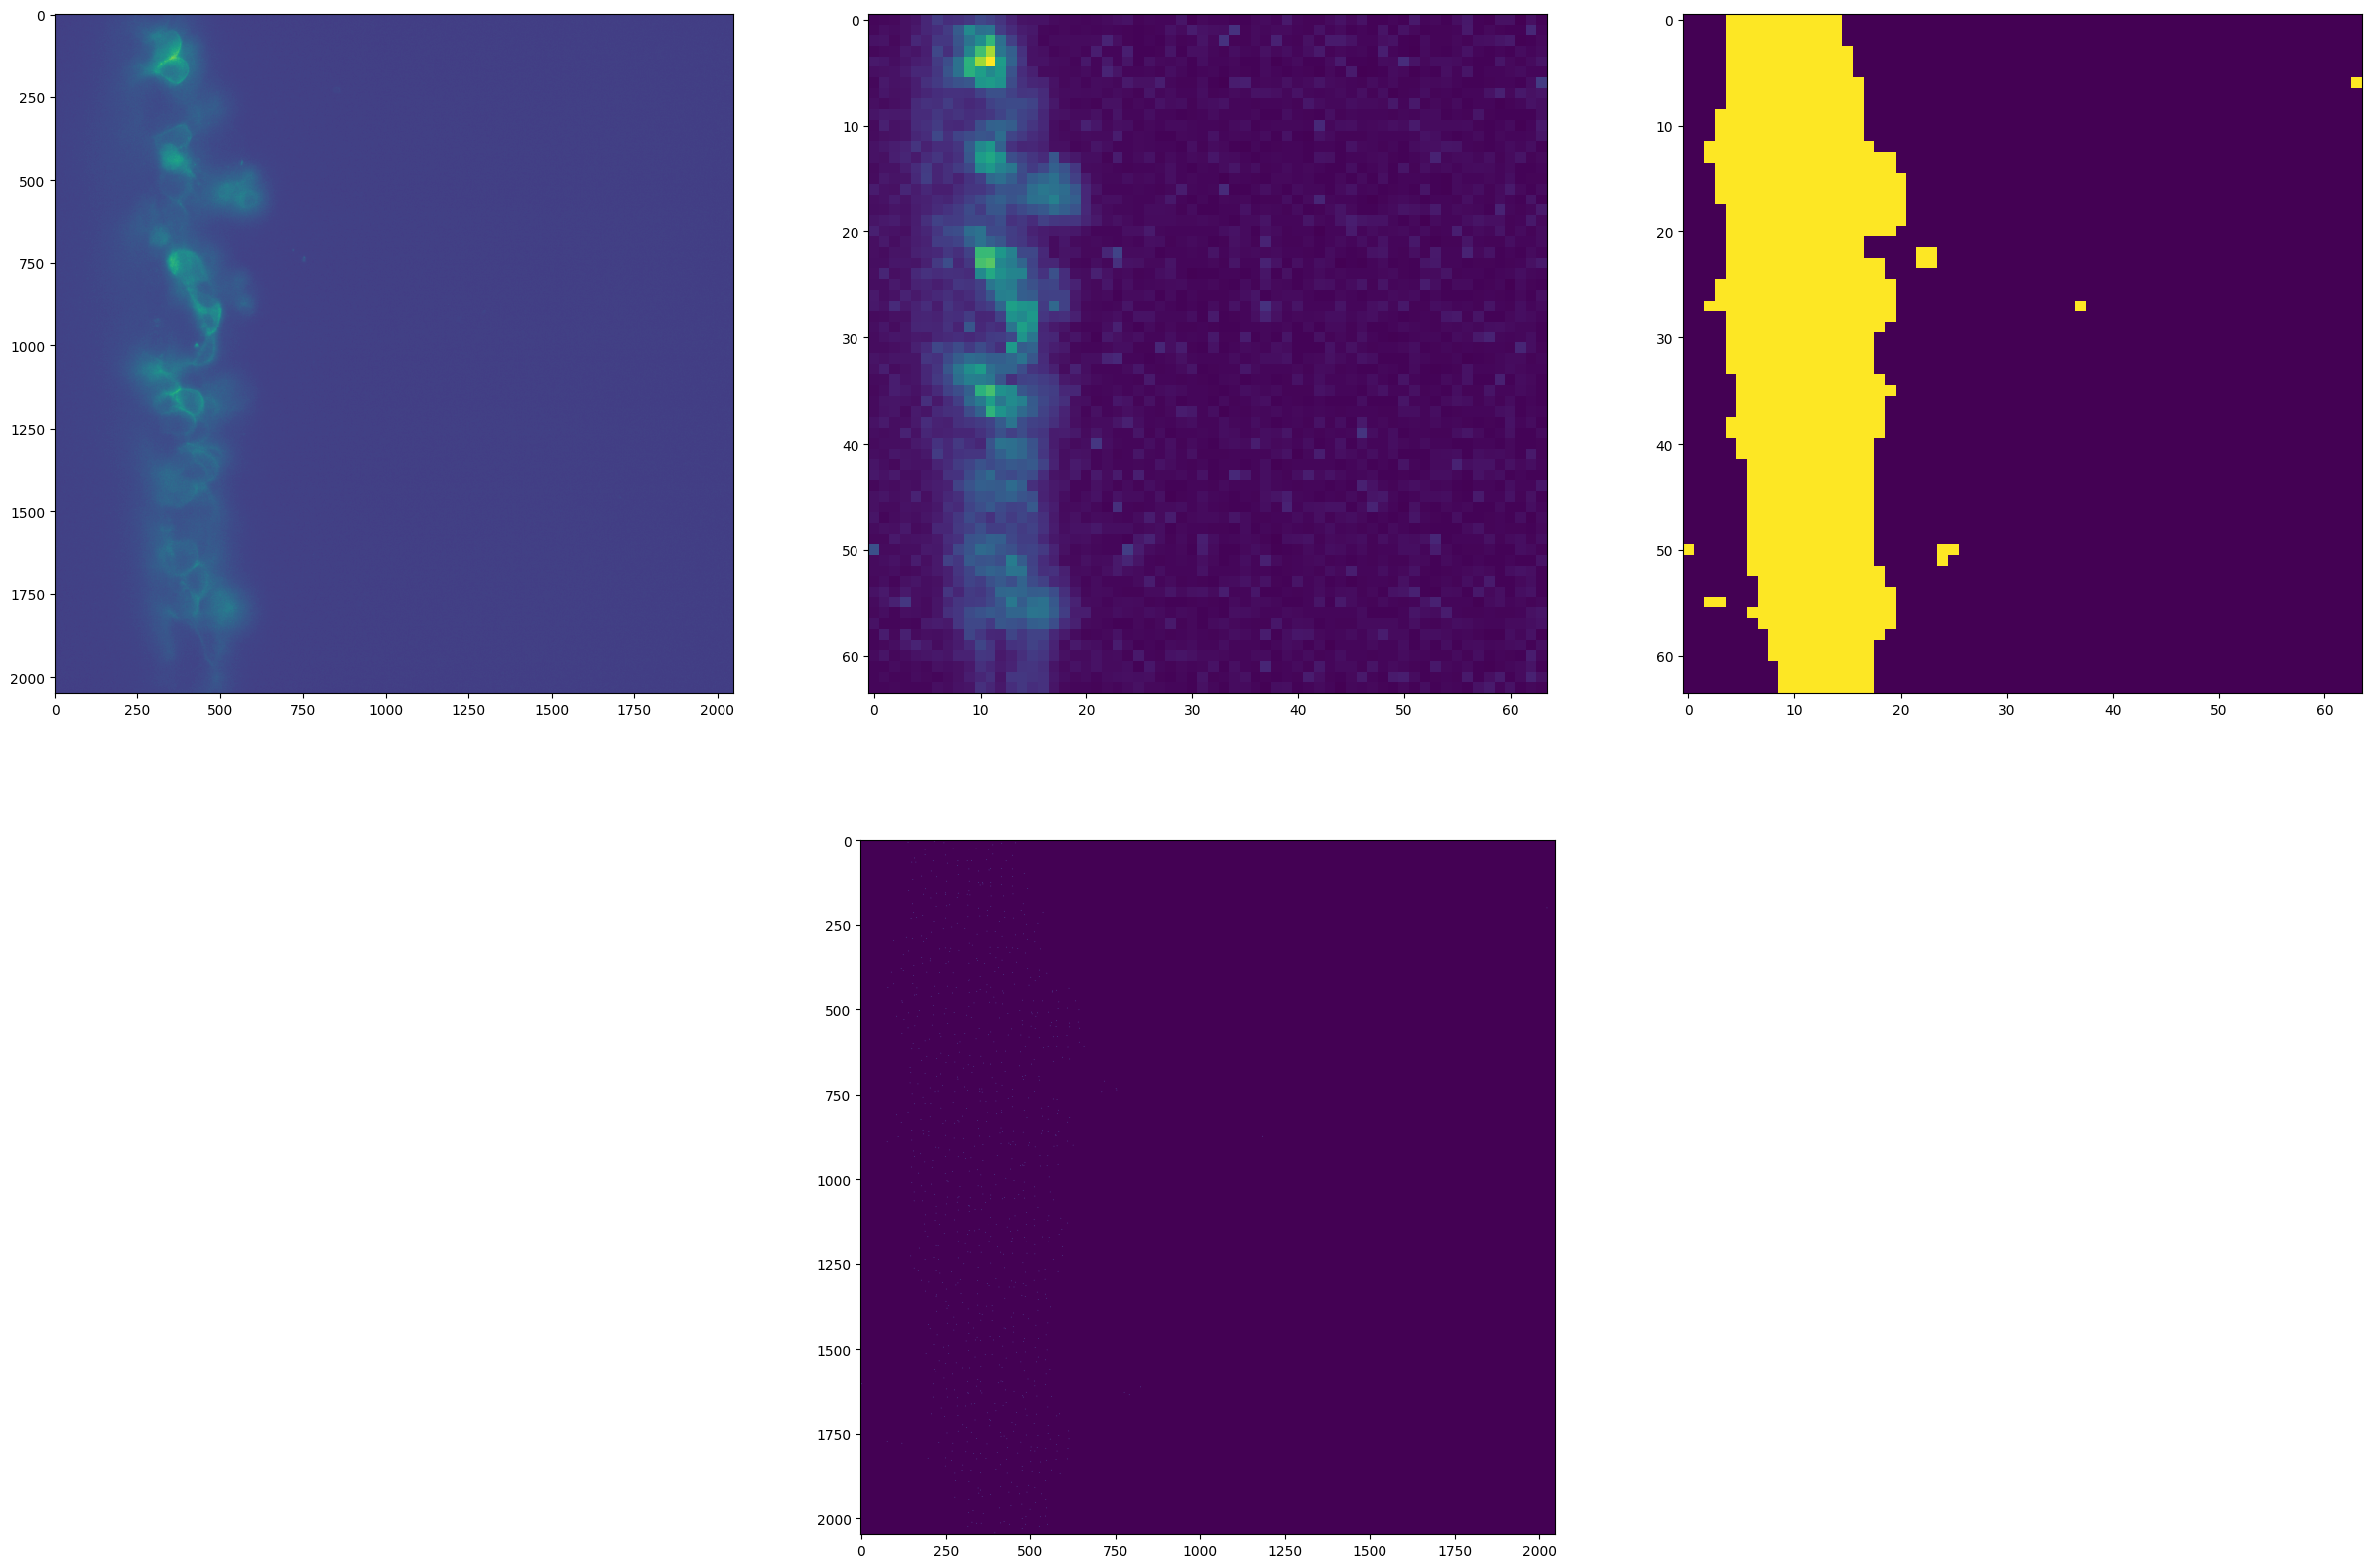

In [62]:
def poolAndMax2D(input, pool=(2,2), v=''):
    v = v.count('+')
    shapeY, shapeX = input.shape[0], input.shape[1] # Original shape of the image
    while shapeY % pool[0] != 0: # If the image Y dimension is not even
        zero_plane = np.zeros_like(input[:pool[0] - input.shape[0] % pool[0], :]) # Create a 2D plane that matches the size of the data
        input = np.concatenate([zero_plane, input], axis=0) # Concatenate the zero-filled plane with the original data
        print(f"Modify Y: {input.shape}, added layer.") if v > 0 else None
    while shapeX % pool[1] != 0: # If the image X dimension is not even
        zero_plane = np.zeros_like(input[:, :pool[1] - input.shape[1] % pool[1]]) # Create a 2D plane that matches the size of the data
        input = np.concatenate([zero_plane, input], axis=1) # Concatenate the zero-filled plane with the original data
        print(f" Modify X: {input.shape}, added layer.") if v > 0 else None
        
    print(input.shape) if v > 0 else None

    shapeY, shapeX = input.shape[0], input.shape[1] # Recompute the shape (new shape)
    newY, newX = int(shapeY/pool[0]), int(shapeX/pool[1]) # The new dimensions that the image will have
    # print(shapeY, shapeX, newY, newX)
    poolList = []
    maxList = [[0 for _ in range(newX)] for _ in range(newY)] # Create a nested list to save the coordinates
    print(f"Convolution from {shapeY} {shapeX} to {len(maxList)} {len(maxList[0])}") if v else None

    c = 0
    perc = 0
    total = int(newX*newY)
    for y in range(0, shapeY, pool[0]):
        for x in range(0, shapeX, pool[1]):
            patch = input[y:y+pool[0], x:x+pool[1]] # Create the patch of pool dimension
            poolList.append(patch.max()) # Get the max value of the patch and append it to the list
            
            indices = np.unravel_index(np.argmax(patch), patch.shape) # Find the indices of the max value
            maxList[int(y / pool[0])][int(x / pool[1])] = (y + indices[0], x + indices[1]) # Add the coordinates in the position of the patch in the list
            
            c+=1
            print(f"{c}/{total}, {perc}%", end="\r") if int(c*100/total) > perc and v > 1 else None 
            perc += 1 if int(c*100/total) > perc else 0
            
    
    print(f"{c}/{total}, {perc}%, DONE!") if v > 1 else None
            
    poolArray = np.array(poolList)
    poolArray = np.reshape(poolArray, (newY, newX))
    maxList = np.array(maxList)
    
    return poolArray, maxList, pool



def deconv2D(input, maxList, pool=(2,2), v=''):
    v = v.count('+')
    shapeY, shapeX = maxList.shape[0], maxList.shape[1]
    newY, newX = int(maxList.shape[0]*pool[0]), int(maxList.shape[1]*pool[1])
    print(f"Deconvolution from {shapeY} {shapeX} to {newY} {newX}") if v > 0 else None
    
    output = [[0 for _ in range(newX)] for _ in range(newY)] # Nested list of size input * pool

    c = 0
    perc = 0
    total = int(shapeY*shapeX)
    for y in range(0, shapeY):
        for x in range(0, shapeX):
            indices = maxList[y, x]
            output[indices[0]][indices[1]] = input[y, x] # Add the value of the pixel to the position of the max pixel of the convolution
            
            c+=1
            print(f"{c}/{total}, {perc}%", end="\r") if int(c*100/total) > perc and v > 1 else None 
            perc += 1 if int(c*100/total) > perc else 0
            
    
    print(f"{c}/{total}, {perc}%, DONE!") if v > 1 else None
    
    output = np.array(output)

    return output

z = 2

plt.figure(figsize=(30,20))

plt.subplot(231)
plt.imshow(image[z])

pool1, maxList1, _ = poolAndMax2D(image[z], v='++')
pool2, maxList2, _ = poolAndMax2D(pool1, v='++')
pool3, maxList3, _ = poolAndMax2D(pool2, v='++')
pool4, maxList4, _ = poolAndMax2D(pool3, v='++')
pool5, maxList5, _ = poolAndMax2D(pool4, v='++')
plt.subplot(232)
plt.imshow(pool5)

pool5 = cv2.GaussianBlur(pool5, (3, 3), 0)
mean =  pool5.mean()
pooled_mask = copy.copy(pool5)
pooled_mask[pool5 > mean] = 255
pooled_mask[pool5 <= mean] = 0
plt.subplot(233)
plt.imshow(pooled_mask)


deconv1 = deconv2D(pooled_mask, maxList5, v='++')
deconv2 = deconv2D(deconv1, maxList4, v='++')
deconv3 = deconv2D(deconv2, maxList3, v='++')
deconv4 = deconv2D(deconv3, maxList2, v='++')
deconv5 = deconv2D(deconv4, maxList1, v='++')

plt.subplot(212)
plt.imshow(deconv5)


In [74]:
def conv_deconv2D(im3d, times=5, verbose='+'):
    verbose = verbose.count('+')
    output = []
    counter = 0
    total = im3d.shape[0]
    for i in im3d:
        pool = [0 for _ in range(times)]
        maxList = [0 for _ in range(times)]
        deconv = [0 for _ in range(times)]
        
        c = 0
        for t in range(times): # CONVOLUTION
            if c == 0:
                pool_n, maxList_n, _ = poolAndMax2D(i)
            else:
                pool_n, maxList_n, _ = poolAndMax2D(pool[c-1])
                
            pool[t] = pool_n
            maxList[t] = maxList_n
            c+=1
        
        
        # MAKE THE MASK
        lastPool = cv2.GaussianBlur(pool[c-1], (3, 3), 0)
        mean = lastPool.mean()
        pooled_mask = copy.copy(lastPool)
        pooled_mask[lastPool > mean] = 255
        pooled_mask[lastPool <= mean] = 0
        
        
        c = times
        for t in range(times): # UPCONVOLUTION
            if c == times:
                deconv_n = deconv2D(pooled_mask, maxList[c-1])
            else:
                deconv_n = deconv2D(deconv[times-c-1], maxList[c-1])
                
            deconv[t] = deconv_n
            c-=1
        
        counter += 1
        print(f"{counter}/{total}", end="\r")
    
        output.append(deconv_n)
    
    output = np.array(output)
    return output

In [75]:
points = conv_deconv2D(image)

In [79]:
print(points.shape)

import tifffile as tiff
tiff.imsave('Dome103_raw_points.tif', points)

(161, 2048, 2048)


C:\Users\SPIM\AppData\Local\Temp\ipykernel_12468\1729828016.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('Dome103_raw_points.tif', points)


In [ ]:
import napari
import skimage as sk
import numpy as np
points = sk.io.imread('Dome103_raw_points.tif')
image = sk.io.imread('./domes/Dome103_raw.tif')
viewer = napari.Viewer()
viewer.add_image(points[1:, :, :], scale=np.array([1,0.1625,0.1625]))
viewer.add_image(image[1:, :, :], scale=np.array([1,0.1625,0.1625]))

<Image layer 'Image [1]' at 0x21df7715a50>

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Python_vscode\pynapari\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\Python_vscode\pynapari\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "d:\Python_vscode\pynapari\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "d:\Python_vscode\pynapari\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever
    self._run_once()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once
    handle._run()
  File "C:\Program Fil

# Mask at the fifth binning

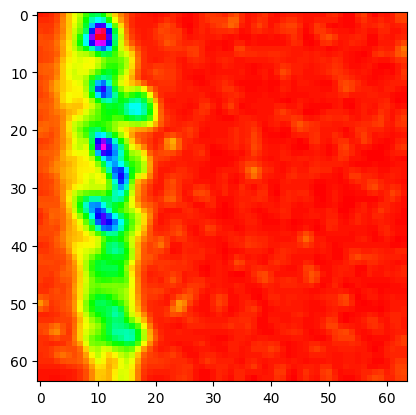

In [63]:
plt.imshow(pool5, cmap='hsv')

142.130126953125
(64, 64)


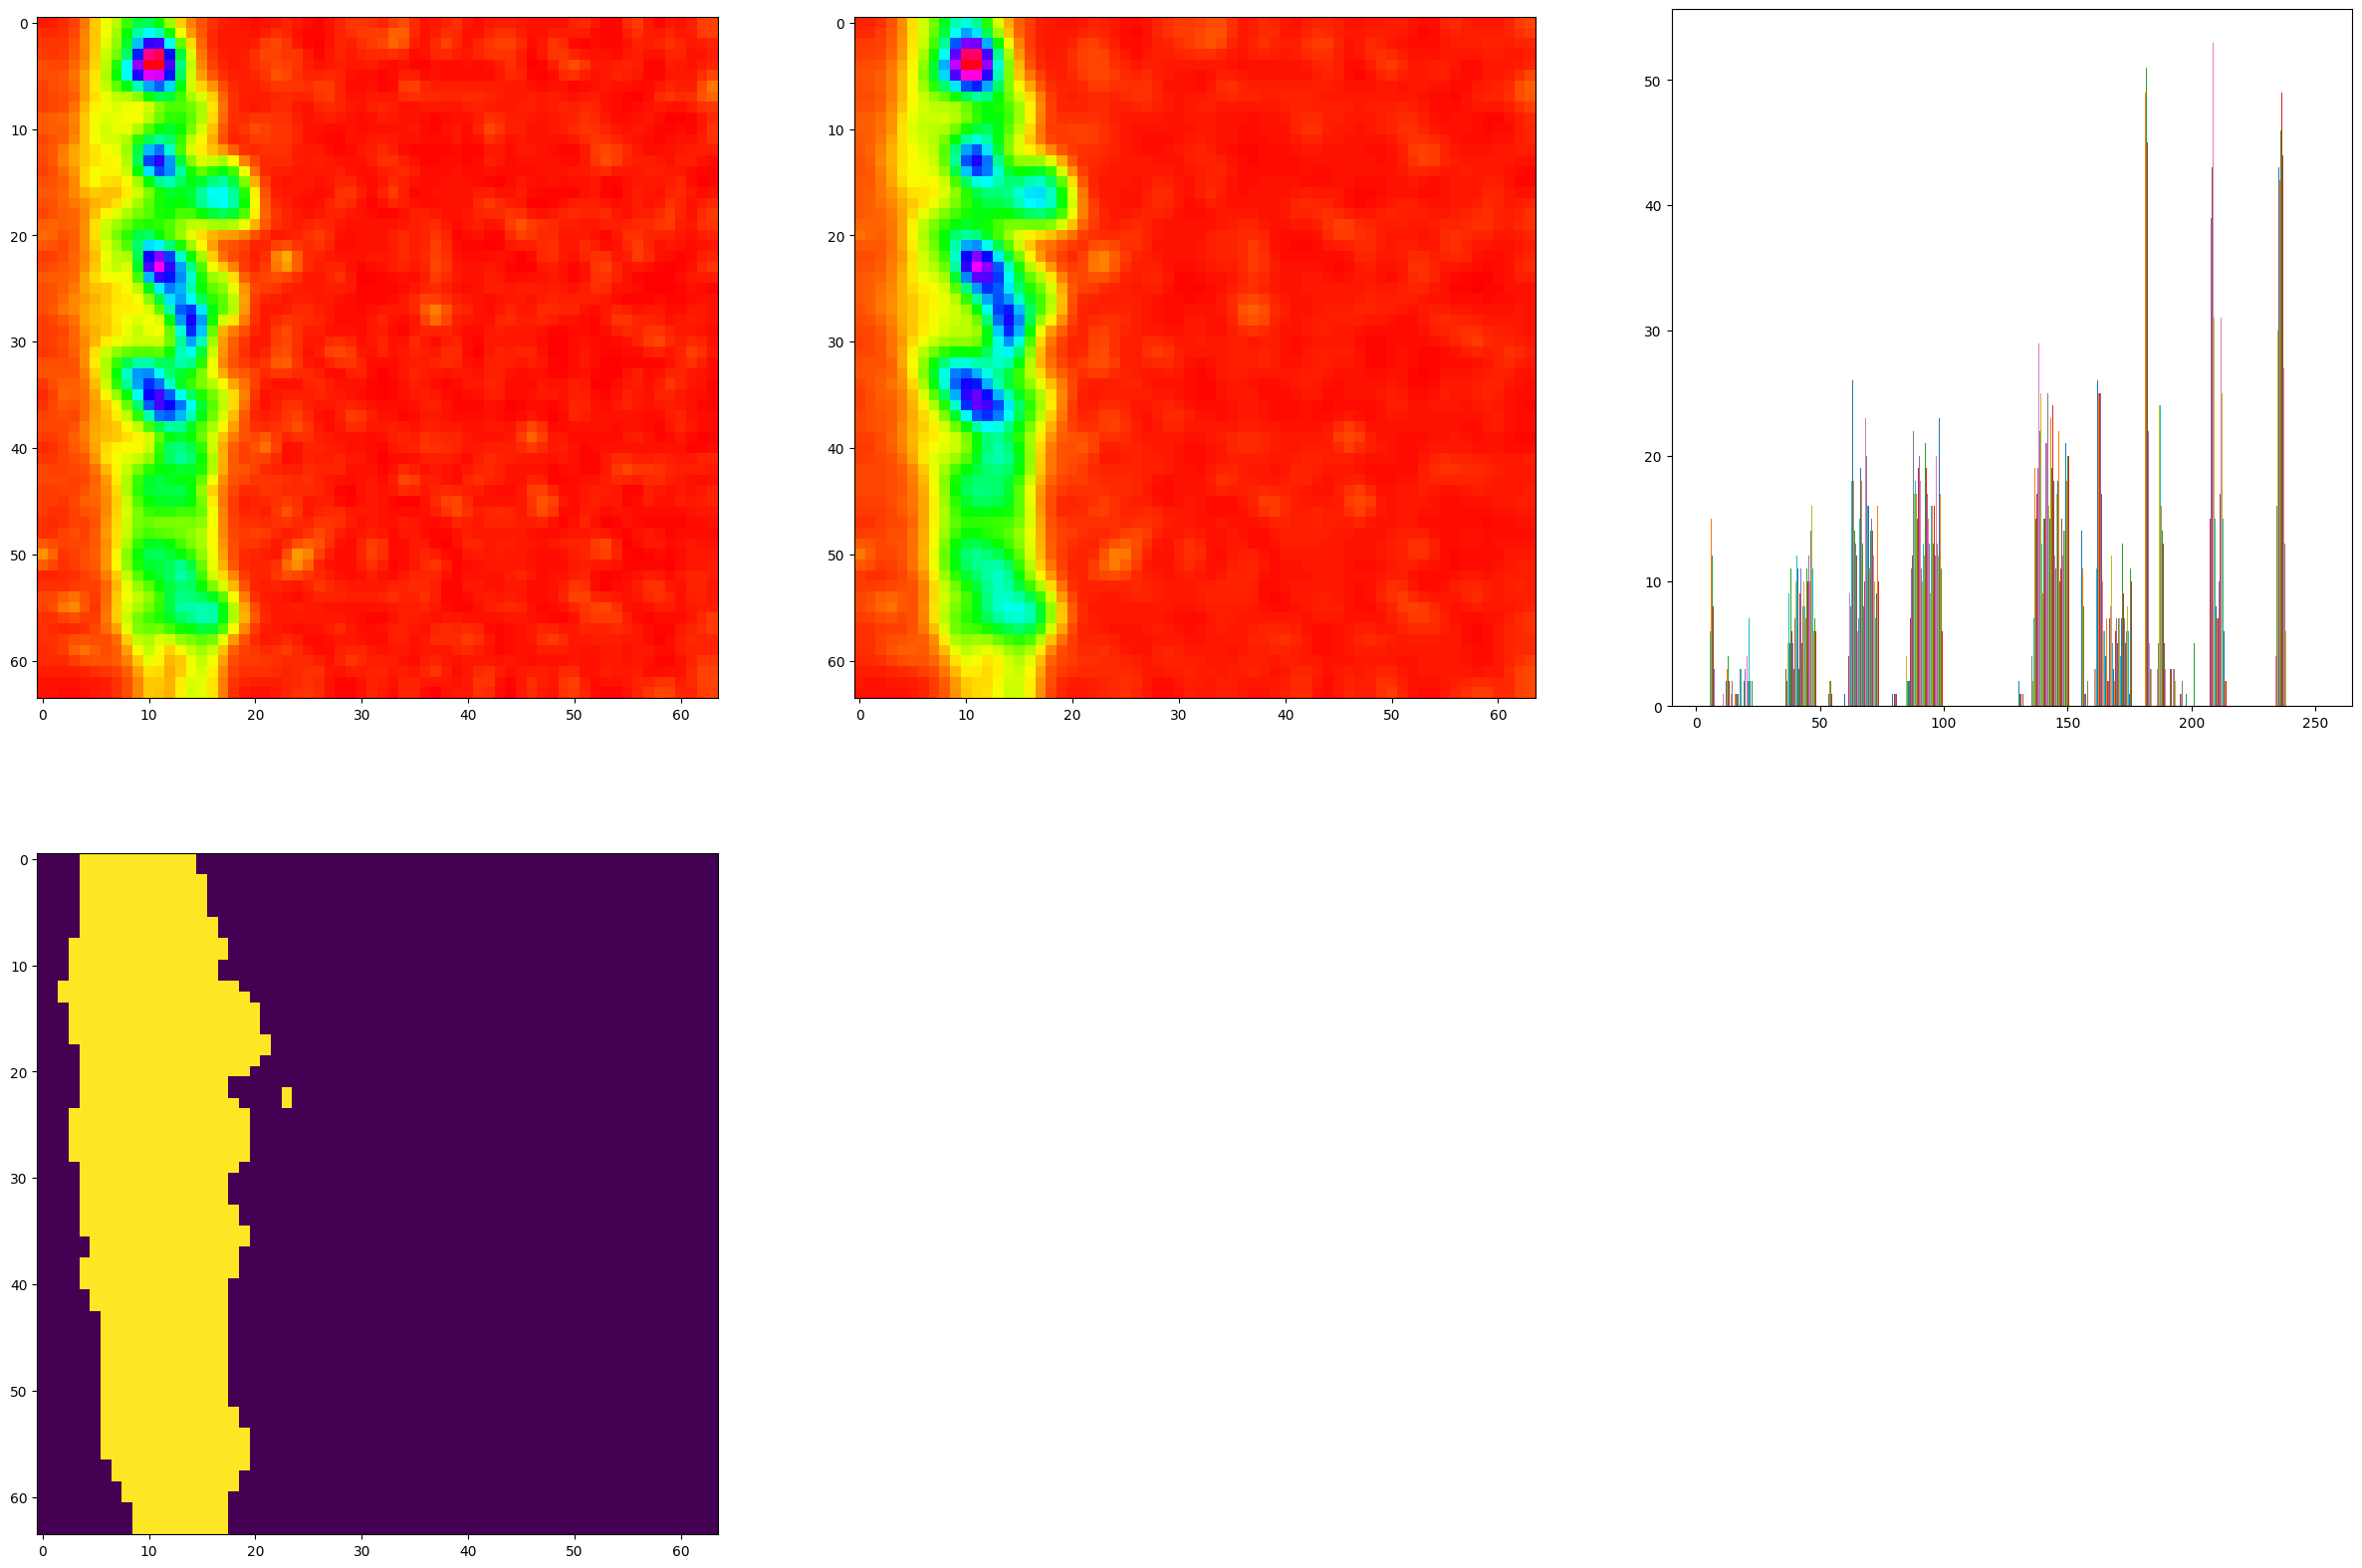

In [64]:
import cv2


plt.figure(figsize=(30,20))

plt.subplot(231)
mask = copy.copy(pool5)
plt.imshow(mask, cmap='hsv')


plt.subplot(232)
mask = cv2.GaussianBlur(mask, (3, 3), 0)
plt.imshow(mask, cmap='hsv')


plt.subplot(233)
hist = cv2.equalizeHist(mask.astype(np.uint8))
plt.hist(hist)



plt.subplot(234)
mean =  mask.mean()
print(mean)
mask2 = copy.copy(mask)
mask2[mask > mean] = 255
mask2[mask <= mean] = 0

# _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

plt.imshow(mask2)


print(mask2.shape)